# **Stock market news feed semantic analysis** *(Baseline Transformers)*

* https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb#scrollTo=IUvWqEq1oV7k
* https://arxiv.org/abs/1706.03762
* https://arxiv.org/abs/1810.04805

## **A projekt előkészítése**

In [2]:
# attach drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/aaron7sun/stocknews

In [3]:
# Copy the dataset to the local environment
!cp "/content/drive/MyDrive/Combined_News_DJIA.csv" "Combined_News_DJIA.csv"

In [4]:
# set imports
import random
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch

In [5]:
# Number of merged news into one string
ROWS = 1 # because of the max length for bert, if removing stop words and punctations will increase

# Shuffle cycle number for the dataframe
SHUFFLE_CYCLE = 500

# Numpy random seed
NP_SEED = 1234

# Torch seed
TORCH_SEED = 1234

# Train percentage (train + valid)
TRAIN_SPLIT = 0.8

# Only validation split
VALIDATION_SPLIT = 0.1

In [6]:
# set seeds for reproduce
random.seed(NP_SEED)
torch.manual_seed(TORCH_SEED)
np.random.seed(NP_SEED)
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(TORCH_SEED)

A Transformers telepítése és importálása.

In [7]:
pip install transformers

     |████████████████████████████████| 2.0MB 3.9MB/s 
     |████████████████████████████████| 3.2MB 47.8MB/s 
     |████████████████████████████████| 890kB 31.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=72ffca694bdcba457a3725fd64c707cede58657e3ad7e6974217bb0ba887e85b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Torchtext frissítése és importálása.

In [9]:
pip install torchtext==0.4.0

     |████████████████████████████████| 61kB 3.1MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [10]:
from torchtext import data

## **Az adathalmaz előkészítése**

In [11]:
# Load the dataset 
df_combined = pd.read_csv('Combined_News_DJIA.csv', index_col = "Date")

# Show the dataframe
df_combined.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

In [12]:
# Find the cells with NaN and after the rows for them
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

# Replace them
df_combined = df_combined.replace(np.nan, " ")

# Check the process
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

assert len(rows_with_NaN) is 0

In [13]:
# correct the wrong labels in the dataset

# Load the stock data
df_stock = web.DataReader("DJIA", data_source="yahoo", start="2008-08-08", 
                          end="2016-07-01")

temp_day = []

for day in range(len(df_stock)):
    temp_day.append(df_stock.index[day].date())

df_stock.index = temp_day

difference = []

if len(df_combined) == len(df_stock):
    print("The lengths are the same!")

for day in range(max(len(df_combined), len(df_stock))):
    if str(df_combined.index[day]) != str(df_stock.index[day]):
        print("There is difference at: " + str(day) + " index")
        print("News: " + str(df_combined.index[day]) + "\tStock: " + str(df_stock.index[day]))
        difference.append(day)

if len(difference) is 0:
    print("The dates matched!")

    difference = []

for day in range(len(df_stock)):
    # label should be 1 -> rise
    if int(df_stock["Adj Close"][day]) >= int(df_stock["Adj Close"][day - 1]):
        if df_combined["Label"][day] != 1:
            difference.append(str(df_stock.index[day]))
            print("Problem at day " + str(df_stock.index[day]))
            print("Today: " + str(df_stock["Adj Close"][day]) +"\t\tYesterday: " + str(df_stock["Adj Close"][day - 1]) + "\t\tLabel: " + str(df_combined["Label"][day]) + "\n")

    # label should be 0 -> fall
    if int(df_stock["Adj Close"][day]) < int(df_stock["Adj Close"][day - 1]):
        if df_combined["Label"][day] != 0:
            difference.append(str(df_stock.index[day]))
            print("Problem at day " + str(df_stock.index[day]))
            print("Today: " + str(df_stock["Adj Close"][day]) +"\t\tYesterday: " + str(df_stock["Adj Close"][day - 1]) + "\t\tLabel: " + str(df_combined["Label"][day]) + "\n")

print("All differences: " + str(len(difference))) 

# correct the wrong labels
for row in difference:
    if df_combined.loc[row, "Label"] == 0:
        df_combined.loc[row, "Label"] = 1
    else:
        df_combined.loc[row, "Label"] = 0

# check them
for row in difference:
    print(str(row) + "\t\t" + str(df_combined.loc[row, "Label"]))

The lengths are the same!
The dates matched!
Problem at day 2010-10-14
Today: 11096.919921875		Yesterday: 11096.080078125		Label: 0

Problem at day 2012-11-12
Today: 12815.080078125		Yesterday: 12815.3896484375		Label: 0

Problem at day 2012-11-15
Today: 12570.9501953125		Yesterday: 12570.9501953125		Label: 0

Problem at day 2013-04-12
Today: 14865.0595703125		Yesterday: 14865.1396484375		Label: 0

Problem at day 2014-04-24
Today: 16501.650390625		Yesterday: 16501.650390625		Label: 0

Problem at day 2015-08-12
Today: 17402.509765625		Yesterday: 17402.83984375		Label: 0

Problem at day 2015-11-27
Today: 17813.390625		Yesterday: 17813.390625		Label: 0

All differences: 7
2010-10-14		1
2012-11-12		1
2012-11-15		1
2013-04-12		1
2014-04-24		1
2015-08-12		1
2015-11-27		1


In [14]:
# the last 10 day save out for testing and comparing the models
df_for_test = df_combined.tail(10)
df_combined.drop(df_combined.tail(10).index,inplace=True) # drop last n rows

In [15]:
df_for_test

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-20,1,A staggering 87 percent of Venezuelans say the...,Two corporate whistleblowers may enter into pl...,"Poland, together with Russia, Iran, and severa...",Three environmental activists were killed per ...,"Ontario funeral business dissolves the dead, p...",New Declassified Documents Reveal How CIA Abus...,Tens of thousands of people gathered in swelte...,Japan's dementia crisis hits record levels as ...,"Icelands Hekla volcano, a very popular tourist...",Corbyn pledges to kill TTIP if elected,Venezuelans Ransack Stores as Hunger Grips the...,Rome elects first female mayor,Saudi Arabia and Kuwait angry about Hillary Cl...,Professor Dismissed for Insulting Turkey's Pre...,Russian soldier dies in Syria after preventing...,"Three dead, 45 injured as labor union clashes ...",Indonesia vows to stand firm after skirmishes ...,A study of ocean plankton has shown that an in...,Australia taxes foreign home buyers as afforda...,Paris isn't happy about Amazon's one-hour deli...,Australian man pleads guilty to making sexual ...,Trudeau condemns killing of 14 Canadian Embass...,Vladimir Putin is considering selling part of ...,An elephant has survived being shot in the hea...,Wikileaks founder Julian Assange marks 5 years...
2016-06-21,1,An Australian athlete who has competed in six ...,Russian state television accidentally broadcas...,"In 2015, 50 environmentalists were killed in B...",China's plan to cut meat consumption by 50% ch...,Coral bleaching event now biggest in history ...,Super-rich quaff champagne in Venezuela countr...,Hong Kong bookseller refuses to be silenced af...,Chinese prosecutors have successfully sued a c...,A London-based advocacy group says it has docu...,Erdogan loses appeal against German media boss,Chinese supercomputer is the world's fastest ...,7-Eleven operator handed record penalty of mor...,A Honduran military unit trained by US was ord...,African Union plans to introduce single passpo...,More refugees became citizens of Canada than a...,Turkey charges Reporters Without Borders press...,Brussels: Bomb alert at shopping centre sparks...,Australian Paralympian Liesl Tesch robbed at g...,China issues orders to demolish Buddhist 'town...,Gazans squeezed by triple taxes as Hamas repla...,US and Russian fighters in dramatic showdown o...,Rising Tide of 'Politically Acceptable' Killin...,Mexico teachers protest: Six people are dead a...,Canada is set to launch a paid whistleblower p...,Russian football fan leader Alexander Shprygin...
2016-06-22,0,German government agrees to ban fracking indef...,Teenage recruits were raped by staff and force...,Pakistan is selling nuclear materials to N Kor...,Amazon jaguar shot dead at Olympic torch ceremony,Mexican flags raised around Donald Trump's gol...,EU smashes 2020 emissions target six years ear...,Police kill eight striking Mexican teachers as...,Pro-choice activists have delivered abortion p...,A French football fan shoved an 18cm-long flar...,Indian space agency ISRO launches 20 satellite...,Japanese power company TEPCO admits it lied ab...,Murdoch's News Corp buys 72 regional newspaper...,"""Europe's growing army of robot workers could ...",Intel Fights Record $1.2 Billion Antitrust Fin...,Russian security service conducts raids on Chu...,Turkish students and graduates from 370 school...,"Japan Election Campaign Kicks off, Voting Age ...",Moscow has signed an agreement with Los Angele...,TEPCO admits meltdown cover-up - The president...,Indian State Grants Jews Minority Status - Ind...,Canadian Rescue Plane successfully reaches Sou...,The Swedish parliament on Tuesday voted in fav...,French police teargas migrants trying to board...,Qawwali musician Amjad Sabri was shot dead in ...,N. Korea launches what appears to be Musudan m...
2016-06-23,1,Today The United Kingdom decides whethe

In [16]:
# combine the news and remove the 'b' char at the beginning
# no other preprocess, the tokenizer will take care of it

# Get column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# 2D array creation for the news based on macros
COLUMNS = len(df_combined)
news_sum = [[0 for i in range(COLUMNS)] for j in range(int((len(combined_column_names) - 1) / ROWS))]  

# Merge the news
for row in range(len(df_combined)):
  for column in range(int((len(combined_column_names) - 1) / ROWS)):
    temp = ""
    news = ""
    for word in range(ROWS):
      news = df_combined[combined_column_names[(column * ROWS) + (word + 1)]][row]
      # Remove the b character at the begining of the string
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[column][row] = temp

# Drop the old columns
for column in range(len(combined_column_names) - 1):
  df_combined.drop(combined_column_names[column + 1], axis = 1, inplace = True)

# Create the new columns with the merged news
for column in range(int((len(combined_column_names) - 1) / ROWS)):
  colum_name = "News_" + str(column + 1)
  df_combined[colum_name] = news_sum[column]

# Show the DataFrame
df_combined.head()

,Label,News_1,News_2,News_3,News_4,News_5,News_6,News_7,News_8,News_9,News_10,News_11,News_12,News_13,News_14,News_15,News_16,News_17,News_18,News_19,News_20,News_21,News_22,News_23,News_24,News_25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into So...,'Russian tanks are moving towards the capital...,"""Afghan children raped with 'impunity,' U.N. ...",'150 Russian tanks have entered South Ossetia...,"""Breaking: Georgia invades South Ossetia, Rus...","""The 'enemy combatent' trials are nothing but...",'Georgian troops retreat from S. Osettain cap...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack ...,'Announcing:Class Action Lawsuit on Behalf of...,"""So---Russia and Georgia are at war and the N...","""China tells Bush to stay out of other countr...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia ge...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to p...",'This is a busy day: The European Union has ...,"""Georgia will withdraw 1,000 soldiers from Ir...",'Why the Pentagon Thinks Attacking Iran is a ...,'Caucasus in crisis: Georgia invades South Os...,'Indian shoe manufactory - And again in a se...,'Visitors Suffering from Mental Illnesses Ban...,"""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,'Why wont America and Nato help us? If they w...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli ...",'Georgian army flees in disarray as Russians ...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zea...,'Russia angered by Israeli military sale to G...,'An American citizen living in S.Ossetia blam...,'Welcome To World War IV! Now In High Definit...,"""Georgia's move, a mistake of monumental prop...",'Russia presses deeper into Georgia; U.S. say...,'Abhinav Bindra wins first ever Individual Ol...,' U.S. ship heads for Arctic to define territ...,'Drivers in a Jerusalem taxi station threaten...,'The French Team is Stunned by Phelps and the...,'Israel and the US behind the Georgian aggres...,"'""Do not believe TV, neither Russian nor Geor...",'Riots are still going on in Montreal (Canada...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Tort...,' Russia has just beaten the United States ov...,'Perhaps *the* question about the Georgia - R...,'Russia is so much better at war',"""So this is what it's come to: trading sex fo..."
2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would hav...","""Al-Qa'eda is losing support in Iraq because ...",'Ceasefire in Georgia: Putin Outmaneuvers the...,'Why Microsoft and Intel tried to kill the XO...,'Stratfor: The Russo-Georgian War and the Bal...,"""I'm Trying to Get a Sense of This Whole Geor...","""The US military was surprised by the timing ...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the S...",'CNN use footage of Tskhinvali ruins to cover...,'Beginning a war as the Olympics were opening...,'55 pyramids as large as the Luxor stacked in...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know t...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious ...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led y...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgi...,'Christopher King argues that the US and NATO...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,' U.S. refuses Israel weapons to attack Iran:...,"""When the president ordered to attack Tskhinv...",' Israel clears troops who killed Reut

In [17]:
# create new dataset without the dates
news_sum = []
label_sum = []

# Get the column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# Connect the merged news with the labels
for column in range(len(df_combined)):
  for row in range(len(combined_column_names) - 1):
    news_sum.append(df_combined[combined_column_names[row + 1]][column])
    label_sum.append(df_combined[combined_column_names[0]][column])

# Create the new DataFrame
df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

# Show it
df_sum_news_labels.head()

,Label,News
0,0,"""Georgia 'downs two Russian warplanes' as cou..."
1,0,'BREAKING: Musharraf to be impeached.'
2,0,'Russia Today: Columns of troops roll into So...
3,0,'Russian tanks are moving towards the capital...
4,0,"""Afghan children raped with 'impunity,' U.N. ..."


In [18]:
# check and delete the null length cells
news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1

print(null_indexes)

for row in null_indexes:
  df_sum_news_labels = df_sum_news_labels.drop(row)

news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1
  
assert len(null_indexes) is 0

[]


In [19]:
# shuffle the dataset
# Do the shuffle
for i in range(SHUFFLE_CYCLE):
  df_sum_news_labels = shuffle(df_sum_news_labels, random_state = NP_SEED)

# Reset the index
df_sum_news_labels.reset_index(inplace=True, drop=True)

In [20]:
# check max length for bert tokenizer
# Get the column names
combined_column_names = []
for column in df_sum_news_labels.columns:
  combined_column_names.append(column)

max_length = 0
# Connect the merged news with the labels
for column in range(len(df_sum_news_labels)):
  for row in range(len(combined_column_names) - 1):
    if len(df_sum_news_labels[combined_column_names[row + 1]][column]) > max_length:
        max_length = len(df_sum_news_labels[combined_column_names[row + 1]][column])

max_length

312

In [21]:
# split the dataset for train and validation and test 
INPUT_SIZE = len(df_sum_news_labels)
# 75% train -> 60% train, 15% valid, 25% test
TRAIN_SIZE = int(TRAIN_SPLIT * INPUT_SIZE) 
VALID_SIZE = int(VALIDATION_SPLIT * TRAIN_SIZE)

# Create the train data set
train_dataset = df_sum_news_labels[:TRAIN_SIZE - VALID_SIZE] 

# Create the validation data set
valid_dataset = df_sum_news_labels[TRAIN_SIZE - VALID_SIZE:TRAIN_SIZE] 

# Create the test data set
test_dataset = df_sum_news_labels[TRAIN_SIZE:]

# Save them without the indexes
train_dataset.to_csv('drive/MyDrive/train.tsv', sep = '\t', index=False)
valid_dataset.to_csv('drive/MyDrive/valid.tsv', sep = '\t', index=False)
test_dataset.to_csv('drive/MyDrive/test.tsv', sep = '\t', index=False)

In [22]:
# check label percentage
# TRAIN
# Groupby by label
labels = train_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print("TRAIN\n")
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

# VALID
# Groupby by label
labels = valid_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print("\n\nVALID\n")
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

# TEST
# Groupby by label
labels = test_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print("\n\nTEST\n")
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

TRAIN

0 Labels percentage: 46.12%

1 Labels percentage: 53.88%


VALID

0 Labels percentage: 45.63%

1 Labels percentage: 54.37%


TEST

0 Labels percentage: 46.63%

1 Labels percentage: 53.37%


In [23]:
train_dataset["News"][0]

'Obama to travel to Cuba President Barack Obama is planning to travel to Cuba within the next month, becoming the first U.S. president to do so since Calvin Coolidge.'

## **Szótárak létrehozása a szöveg kódolásához**

In [24]:
# define max input length for bert
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [25]:
# preprocess function with tokenizer
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [26]:
# special tokens
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [27]:
# fields define
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [28]:
fields = [('labels', LABEL), ('news', TEXT)]

In [29]:
# load datasets
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = "drive/MyDrive",
                                        train = "train.tsv",
                                        validation = "valid.tsv",
                                        test = "test.tsv",
                                        format = "tsv",
                                        fields = fields,
                                        skip_header = True
)

In [30]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 35622
Number of validation examples: 3958
Number of testing examples: 9895


Az első elem ellenőrzése.

In [31]:
print(vars(train_data[0]))

{'labels': '1', 'news': [8112, 2000, 3604, 2000, 7394, 2343, 13857, 8112, 2003, 4041, 2000, 3604, 2000, 7394, 2306, 1996, 2279, 3204, 1010, 3352, 1996, 2034, 1057, 1012, 1055, 1012, 2343, 2000, 2079, 2061, 2144, 11130, 4658, 13623, 1012]}


In [32]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data[0])['news'])

print(tokens)

['obama', 'to', 'travel', 'to', 'cuba', 'president', 'barack', 'obama', 'is', 'planning', 'to', 'travel', 'to', 'cuba', 'within', 'the', 'next', 'month', ',', 'becoming', 'the', 'first', 'u', '.', 's', '.', 'president', 'to', 'do', 'so', 'since', 'calvin', 'cool', '##idge', '.']


In [33]:
# build vocab
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '0': 1})


In [34]:
# define batch and iterator
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key = lambda x: x.news, #sort by n attribute (quote)
    batch_size = BATCH_SIZE, 
    sort_within_batch = True,
    device = device)

## **Modell létrehozása**

In [35]:
# load pretrained bert
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

In [36]:
# define model
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert # bert layer
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout) # gru layer
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim) # linear out
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0] # do not teach the bert layer parameters
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [37]:
# create the model with parameters
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [38]:
# check all and teachable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} parameters')

#for name, param in model.named_parameters():                
#    if name.startswith('bert'):
#        param.requires_grad = False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 110,765,057 parameters
The model has 110,765,057 trainable parameters


## **A modell tanítása**

In [39]:
# optimizier and cost function
import torch.optim as optim
LR = 0.0001

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown=5, 
#                                                       patience=5, verbose=True)

# place them to gpu
model = model.to(device)
criterion = criterion.to(device)

In [40]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [41]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    index = 0
    log_interval = 100
    
    model.train()
    
    for batch in iterator:
        if index == 0:
            all = str(len(iterator))
            print(f'Epoch: {epoch+1:02} started | {all} batches will be done')

        if index % log_interval == 0 and index > 0:
            all = str(len(iterator))
            temp_end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, temp_end_time)
            print(f'Epoch: {epoch+1:02} | {index} / {all} batches done | Epoch Time: {epoch_mins}m {epoch_secs}s')
            
        optimizer.zero_grad()
        
        predictions = model(batch.news).squeeze(1)
        
        loss = criterion(predictions, batch.labels)
        
        acc = binary_accuracy(predictions, batch.labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        index += 1
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [42]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.news).squeeze(1)
            
            loss = criterion(predictions, batch.labels)
            
            acc = binary_accuracy(predictions, batch.labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
# train the model
# save the results for plotting
N_EPOCHS = 100

train_loss_array = []
train_acc_array = []
valid_loss_array = []
valid_acc_array = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
#    scheduler.step(valid_loss)

    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    valid_loss_array.append(valid_loss)
    valid_acc_array.append(valid_acc)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/bert_best_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%\n')

KeyboardInterrupt: ignored

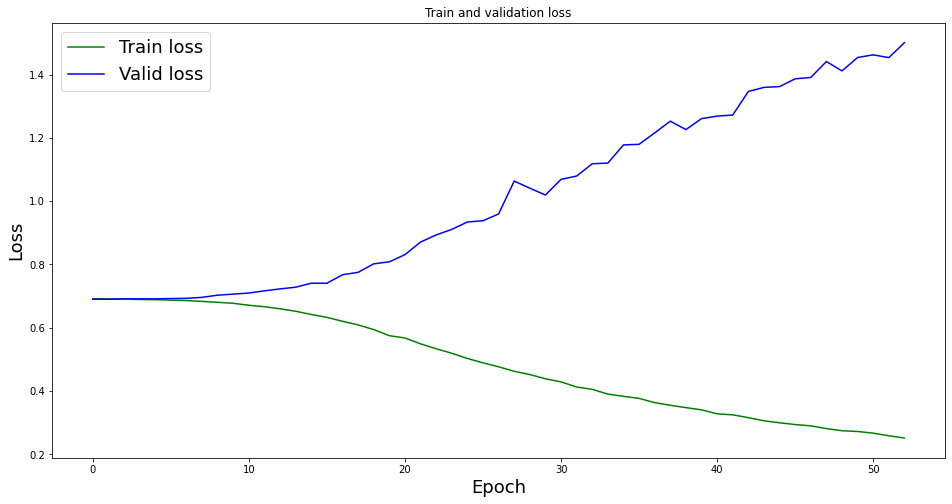

In [47]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

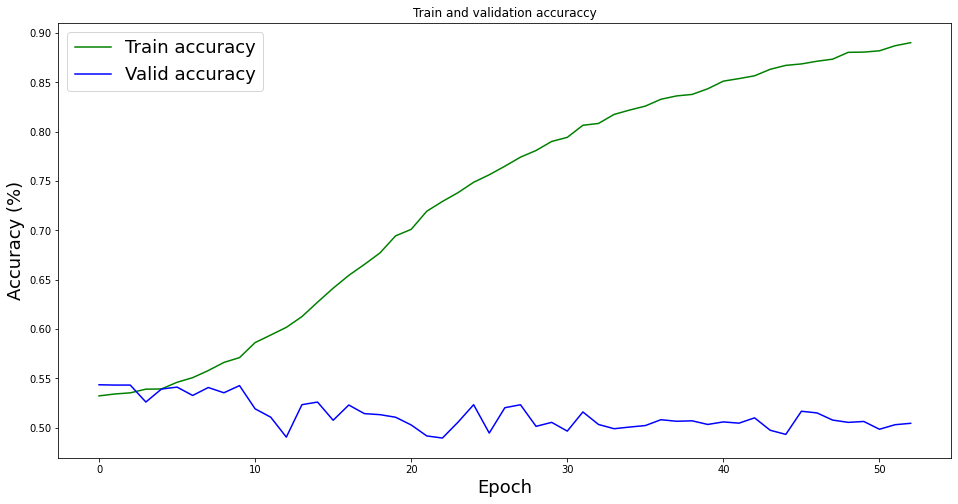

In [48]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation accuraccy')
plt.plot(train_acc_array, color = "green", label = "Train accuracy")
plt.plot(valid_acc_array, color = "blue", label = "Valid accuracy")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy (%)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

## **A modell tesztelése**

In [49]:
model.load_state_dict(torch.load('drive/MyDrive/bert_best_model.pt', map_location=torch.device('cpu')))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.692 | Test Acc: 53.36%


A többi modellel való összehasonlításhoz szükséges táblázat megalkotása.

In [44]:
# compare with other models
# combine the news and remove the 'b' char at the beginning
# no other preprocess, the tokenizer will take care of it

# Get column names
combined_column_names = []
for column in df_for_test.columns:
  combined_column_names.append(column)

# 2D array creation for the news based on macros
COLUMNS = len(df_for_test)
news_sum = [[0 for i in range(COLUMNS)] for j in range(int((len(combined_column_names) - 1) / ROWS))]  

# Merge the news
for row in range(len(df_for_test)):
  for column in range(int((len(combined_column_names) - 1) / ROWS)):
    temp = ""
    news = ""
    for word in range(ROWS):
      news = df_for_test[combined_column_names[(column * ROWS) + (word + 1)]][row]
      # Remove the b character at the begining of the string
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[column][row] = temp

# Drop the old columns
for column in range(len(combined_column_names) - 1):
  df_for_test.drop(combined_column_names[column + 1], axis = 1, inplace = True)

# Create the new columns with the merged news
for column in range(int((len(combined_column_names) - 1) / ROWS)):
  colum_name = "News_" + str(column + 1)
  df_for_test[colum_name] = news_sum[column]

# Show the DataFrame
df_for_test.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Label,News_1,News_2,News_3,News_4,News_5,News_6,News_7,News_8,News_9,News_10,News_11,News_12,News_13,News_14,News_15,News_16,News_17,News_18,News_19,News_20,News_21,News_22,News_23,News_24,News_25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-20,1,A staggering 87 percent of Venezuelans say the...,Two corporate whistleblowers may enter into pl...,"Poland, together with Russia, Iran, and severa...",Three environmental activists were killed per ...,"Ontario funeral business dissolves the dead, p...",New Declassified Documents Reveal How CIA Abus...,Tens of thousands of people gathered in swelte...,Japan's dementia crisis hits record levels as ...,"Icelands Hekla volcano, a very popular tourist...",Corbyn pledges to kill TTIP if elected,Venezuelans Ransack Stores as Hunger Grips the...,Rome elects first female mayor,Saudi Arabia and Kuwait angry about Hillary Cl...,Professor Dismissed for Insulting Turkey's Pre...,Russian soldier dies in Syria after preventing...,"Three dead, 45 injured as labor union clashes ...",Indonesia vows to stand firm after skirmishes ...,A study of ocean plankton has shown that an in...,Australia taxes foreign home buyers as afforda...,Paris isn't happy about Amazon's one-hour deli...,Australian man pleads guilty to making sexual ...,Trudeau condemns killing of 14 Canadian Embass...,Vladimir Putin is considering selling part of ...,An elephant has survived being shot in the hea...,Wikileaks founder Julian Assange marks 5 years...
2016-06-21,1,An Australian athlete who has competed in six ...,Russian state television accidentally broadcas...,"In 2015, 50 environmentalists were killed in B...",China's plan to cut meat consumption by 50% ch...,Coral bleaching event now biggest in history ...,Super-rich quaff champagne in Venezuela countr...,Hong Kong bookseller refuses to be silenced af...,Chinese prosecutors have successfully sued a c...,A London-based advocacy group says it has docu...,Erdogan loses appeal against German media boss,Chinese supercomputer is the world's fastest ...,7-Eleven operator handed record penalty of mor...,A Honduran military unit trained by US was ord...,African Union plans to introduce single passpo...,More refugees became citizens of Canada than a...,Turkey charges Reporters Without Borders press...,Brussels: Bomb alert at shopping centre sparks...,Australian Paralympian Liesl Tesch robbed at g...,China issues orders to demolish Buddhist 'town...,Gazans squeezed by triple taxes as Hamas repla...,US and Russian fighters in dramatic showdown o...,Rising Tide of 'Politically Acceptable' Killin...,Mexico teachers protest: Six people are dead a...,Canada is set to launch a paid whistleblower p...,Russian football fan leader Alexander Shprygin...
2016-06-22,0,German government agrees to ban fracking indef...,Teenage recruits were raped by staff and force...,Pakistan is selling nuclear materials to N Kor...,Amazon jaguar shot dead at Olympic torch ceremony,Mexican flags raised around Donald Trump's gol...,EU smashes 2020 emissions target six years ear...,Police kill eight striking Mexican teachers as...,Pro-choice activists have delivered abortion p...,A French football fan shoved an 18cm-long flar...,Indian space agency ISRO launches 20 satellite...,Japanese power company TEPCO admits it lied ab...,Murdoch's News Corp buys 72 regional newspaper...,"""Europe's growing army of robot workers could ...",Intel Fights Record $1.2 Billion Antitrust Fin...,Russian security service conducts raids on Chu...,Turkish students and graduates from 370 school...,"Japan Election Campaign Kicks off, Voting Age ...",Moscow has signed an agreement with Los Angele...,TEPCO admits meltdown cover-up - The president...,Indian State Grants Jews Minority Status - Ind...,Canadian Rescue Plane successfully reaches Sou...,The Swedish parliament on Tuesday voted in fav...,French police teargas migrants trying to board...,Qawwali musician Amjad Sabri was shot dead in ...,N. Korea launches what appears to be Musudan m...
20

In [45]:
# create new dataset without the dates
news_sum = []
label_sum = []

# Get the column names
combined_column_names = []
for column in df_for_test.columns:
  combined_column_names.append(column)

# Connect the merged news with the labels
for column in range(len(df_for_test)):
  for row in range(len(combined_column_names) - 1):
    news_sum.append(df_for_test[combined_column_names[row + 1]][column])
    label_sum.append(df_for_test[combined_column_names[0]][column])

# Create the new DataFrame
df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

# Show it
df_sum_news_labels.head()

,Label,News
0,1,A staggering 87 percent of Venezuelans say the...
1,1,Two corporate whistleblowers may enter into pl...
2,1,"Poland, together with Russia, Iran, and severa..."
3,1,Three environmental activists were killed per ...
4,1,"Ontario funeral business dissolves the dead, p..."


In [46]:
# check and delete the null length cells
news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1

print(null_indexes)

for row in null_indexes:
  df_sum_news_labels = df_sum_news_labels.drop(row)

news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1
  
assert len(null_indexes) is 0

[]


In [47]:
df_sum_news_labels

,Label,News
0,1,A staggering 87 percent of Venezuelans say the...
1,1,Two corporate whistleblowers may enter into pl...
2,1,"Poland, together with Russia, Iran, and severa..."
3,1,Three environmental activists were killed per ...
4,1,"Ontario funeral business dissolves the dead, p..."
...,...,...
245,1,Philippines president Rodrigo Duterte urges pe...
246,1,Spain arrests three Pakistanis accused of prom...
247,1,"Venezuela, where anger over food shortages is ..."
248,1,A Hindu temple worker has been killed by three...


In [49]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [60]:
predict_raw = []
predict_label = []

for row in range(int(len(df_sum_news_labels) / 25)):
    for i in range(25):
        sent_temp += predict_sentiment(model, tokenizer, df_sum_news_labels["News"][row * 25 + i])
    
    sent_temp = sent_temp / 25
    predict_raw.append(sent_temp)
    predict_label.append(round(sent_temp))

print(predict_raw)
print("\n\n")
print(predict_label)

[0.5551511381590113, 0.5336835767210474, 0.5376930442864932, 0.5351568122999479, 0.5428021250577634, 0.5459572434362248, 0.5493350794312813, 0.5376393718337912, 0.5294230195793148, 0.533707970034729]



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [64]:
# create the table
df_result = df_for_test.drop(df_for_test.columns[1:26],  axis=1)

df_result["Raw"] = predict_raw
df_result["Sentiment"] = predict_label

match = []
for row in range(len(df_result)):
    if df_result["Label"][row] == df_result["Sentiment"][row]:
        match.append(1)
    else:
        match.append(0)

df_result["Match"] = match

df_result

,Label,Raw,Sentiment,Match
Date,,,,
2016-06-20,1,0.555151,1,1
2016-06-21,1,0.533684,1,1
2016-06-22,0,0.537693,1,0
2016-06-23,1,0.535157,1,1
2016-06-24,0,0.542802,1,0
2016-06-27,0,0.545957,1,0
2016-06-28,1,0.549335,1,1
2016-06-29,1,0.537639,1,1
2016-06-30,1,0.529423,1,1
